In [14]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

from src import data, paths,labels
!date -I

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-18


# Schaefer (200 regions) - Glasser (360 regions) mapping using Dice score

We want to compare the response probabilities for selected ROI from F-Tract (see [01_f-tract](../01_f-tract/02_analysis_per_roi.ipynb)) with TMS-EEG responses (see [02_pytepfit](../02_pytepfit/05_analysis.ipynb)). Direct comparison of the TMS-EEG and F-TRACT results is not possible, because they do not share the same brain parcellation. The TMS-EEG dataset is published in Schaefer200 parcellation, which is not available for F-TRACT. Because of that, it is necessary to find a mapping between Glasser and Schaefer200 parcellation.

Lawrence et al. proposed the Dice coefficient as a possibility of similarity evaluation between ROIs across parcellations. For two ROIs $A$ and $B$, each consisting of a set of voxels, the Dice coefficient of association is calculated as  
$$
\frac{2 \cdot |A\cap B|}{|A|+|B|}.
$$
the score is a ratio of the overlap of the regions to the sum of their sizes. It is higher for regions with a big overlap with respect to their sizes.

Lawrence et al. provide a function for calculations of Dice scores between parcellations in Neuroparc repository at GitHub.\footnote{\url{https://github.com/neurodata/neuroparc/blob/5a5e7469671e65cb58087c47b69d0edb71dc2966/scripts/dice_correlation.py}} Using that, Dice score map between Schaefer200 and Glasser parcellations was created and saved as `interim/DICE/DICE_Glasser_Schaefer200_res-1x1x1.csv`.

Having the matrix with Dice scores for each pair of ROIs from Schaefer200 and Glasser, the easiest way to get comparable results is to assign one Schaefer200 ROI to each Glasser ROI based one the highest Dice coefficient (or vice versa, assign Glasser to Schaefer200 ROI). We can use this as a mapping for the vector of response probabilities in F-Tract and response AUC or other characteristics in TMS-EEG. This is done in this notebook.

We try different approach than greedy assignment based on highest Dice score here, greedy implementation can be found in [DICE_02_glasser-schaefer200_maxdice.ipynb](./DICE_02_glasser-schaefer200_maxdice.ipynb).

Load the Dice scores, Glasser labels correspond to rows, Schaefer to columns:

In [15]:
df_dice_schaefer = pd.read_csv( 
    data.path('interim/DICE/DICE_Glasser_Schaefer200_res-1x1x1.csv'),
    index_col=0
)

df_dice_schaefer

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_Vis_10,...,7Networks_RH_Default_PFCdPFCm_1,7Networks_RH_Default_PFCdPFCm_2,7Networks_RH_Default_PFCdPFCm_3,7Networks_RH_Default_PFCdPFCm_4,7Networks_RH_Default_PFCdPFCm_5,7Networks_RH_Default_PFCdPFCm_6,7Networks_RH_Default_PFCdPFCm_7,7Networks_RH_Default_pCunPCC_1,7Networks_RH_Default_pCunPCC_2,7Networks_RH_Default_pCunPCC_3
regionName,,,,,,,,,,,,,,,,,,,,,
V1_L,0.001433,0.001989,0.000000,0.042971,0.112614,0.000000,0.279401,0.0,0.032078,0.290259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
V6_L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
V2_L,0.022989,0.121945,0.000000,0.144727,0.064140,0.011392,0.031769,0.0,0.070741,0.064629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000573,0.0,0.0
V3_L,0.047550,0.144718,0.000000,0.008050,0.049874,0.000000,0.000000,0.0,0.081991,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
V4_L,0.032567,0.177670,0.002828,0.000000,0.072781,0.000000,0.000000,0.0,0.067541,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOP2_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PoI1_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ig_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The table above shows that the dice scores are saved in a way ignoring hemisphere in Glasser; all the scores seem to be assigned to left hemisphere. We want to assign labels from right hemisphere in Schaefer to right hemisphere in Glasser (and left to left). Therefore we mohe the scores in upper right quarter of the matrix to lower right quarter.

In [16]:
dice_schaefer_array = df_dice_schaefer.to_numpy()
n_glasser,n_schaefer = dice_schaefer_array.shape
dice_schaefer_array[n_glasser//2:]=dice_schaefer_array[:n_glasser//2]
dice_schaefer_array[n_glasser//2:,:n_schaefer//2] = np.nan
dice_schaefer_array[:n_glasser//2,n_schaefer//2:] = np.nan
dice_schaefer_array

array([[0.00143277, 0.00198858, 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.02298851, 0.12194461, 0.        , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]])

In [17]:
df_dice_schaefer =  pd.DataFrame(data=dice_schaefer_array,   
                                index=df_dice_schaefer.index, 
                                columns=df_dice_schaefer.columns) 
df_dice_schaefer

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_Vis_10,...,7Networks_RH_Default_PFCdPFCm_1,7Networks_RH_Default_PFCdPFCm_2,7Networks_RH_Default_PFCdPFCm_3,7Networks_RH_Default_PFCdPFCm_4,7Networks_RH_Default_PFCdPFCm_5,7Networks_RH_Default_PFCdPFCm_6,7Networks_RH_Default_PFCdPFCm_7,7Networks_RH_Default_pCunPCC_1,7Networks_RH_Default_pCunPCC_2,7Networks_RH_Default_pCunPCC_3
regionName,,,,,,,,,,,,,,,,,,,,,
V1_L,0.001433,0.001989,0.000000,0.042971,0.112614,0.000000,0.279401,0.0,0.032078,0.290259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V6_L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V2_L,0.022989,0.121945,0.000000,0.144727,0.064140,0.011392,0.031769,0.0,0.070741,0.064629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V3_L,0.047550,0.144718,0.000000,0.008050,0.049874,0.000000,0.000000,0.0,0.081991,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V4_L,0.032567,0.177670,0.002828,0.000000,0.072781,0.000000,0.000000,0.0,0.067541,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOP2_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PoI1_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ig_R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
len(list(df_dice_schaefer.index))

360

<Axes: ylabel='regionName'>

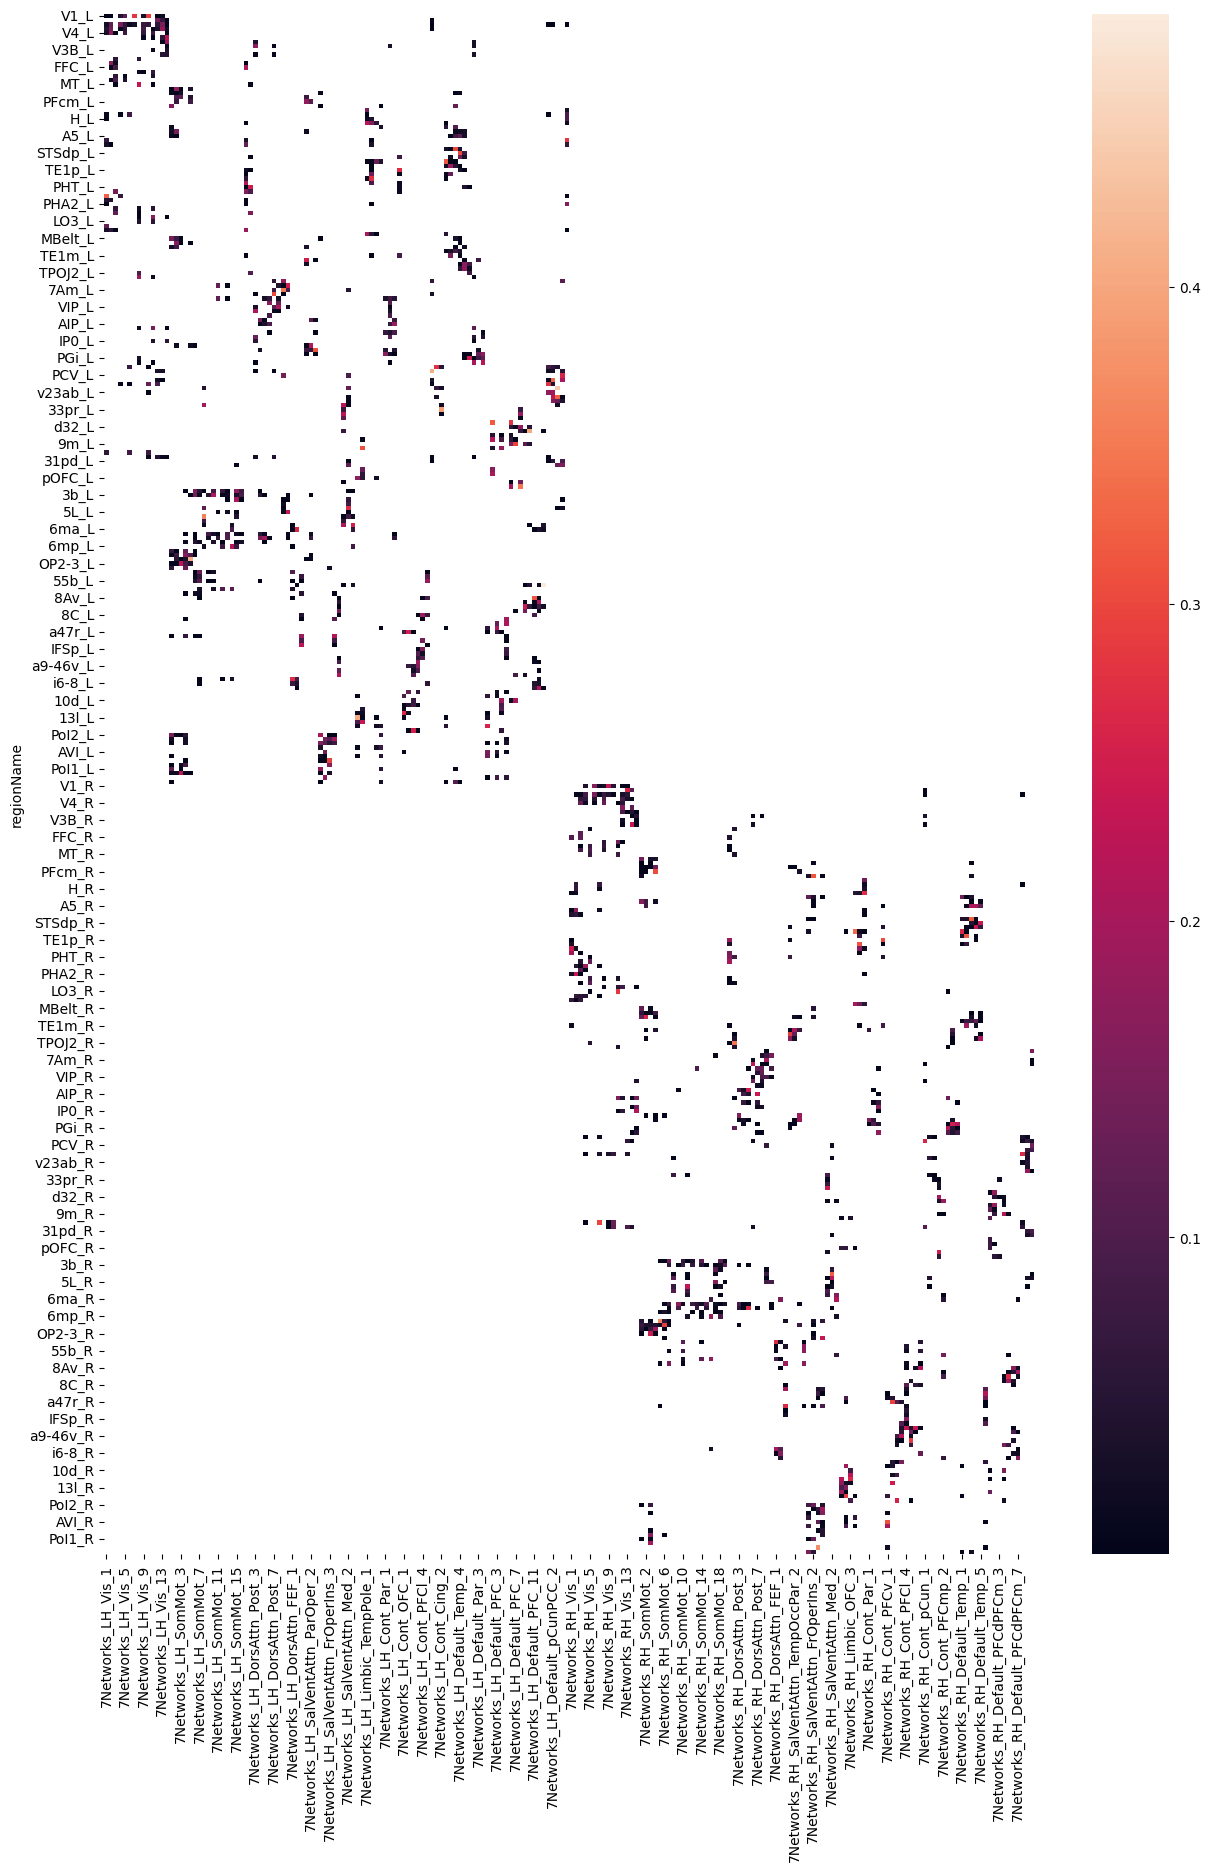

In [19]:
fig, ax = plt.subplots(figsize=(15,20))
sns.heatmap(df_dice_schaefer, mask=df_dice_schaefer == 0.0, ax=ax)

### Crate mapping Glasser-Schaefer200

Plan: First, we want to fing matching using all regions from Schaefer and same number of regions from Glasser, maximizing the sum of Dice scores between the mapped regions. Then, we assign Schaefer regions to the remaining Glasser regions in a greedy way. The idea is that we want to Use all label from both sets.

Use scipy to find the max-matching:

In [22]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(np.nan_to_num(dice_schaefer_array),maximize=True)

Map the labels based on indices obtained above:

In [23]:
df_mapping_one_to_one =  pd.DataFrame({"glasser":np.array(df_dice_schaefer.index)[row_ind], "schaefer":np.array(df_dice_schaefer.columns)[col_ind]}) 
df_mapping_one_to_one

,glasser,schaefer
0,V1_L,7Networks_LH_Vis_7
1,V6_L,7Networks_LH_Vis_12
2,V2_L,7Networks_LH_Vis_4
3,V3_L,7Networks_LH_Vis_13
4,V4_L,7Networks_LH_Vis_9
...,...,...
195,47s_R,7Networks_RH_Limbic_OFC_2
196,p10p_R,7Networks_RH_Cont_PFCl_2
197,AVI_R,7Networks_RH_Cont_PFCv_1
198,FOP5_R,7Networks_RH_SalVentAttn_FrOperIns_3


In [24]:
df_mapping = pd.DataFrame(index=df_dice_schaefer.index)
df_mapping["glasser"]=df_mapping.index
df_mapping

,glasser
regionName,
V1_L,V1_L
V6_L,V6_L
V2_L,V2_L
V3_L,V3_L
V4_L,V4_L
...,...
FOP2_R,FOP2_R
PoI1_R,PoI1_R
Ig_R,Ig_R


Merge with all Glasser labels. Now, we have a dataframe with all Glasser and Schaefer labels, but it contains some NaNs for Glasser labels that are not paired yet:

In [25]:
df_mapping_with_nans = pd.merge(df_mapping,df_mapping_one_to_one,on="glasser",how="left")
df_mapping_with_nans

,glasser,schaefer
0,V1_L,7Networks_LH_Vis_7
1,V6_L,7Networks_LH_Vis_12
2,V2_L,7Networks_LH_Vis_4
3,V3_L,7Networks_LH_Vis_13
4,V4_L,7Networks_LH_Vis_9
...,...,...
355,FOP2_R,NaN
356,PoI1_R,NaN
357,Ig_R,NaN
358,FOP5_R,7Networks_RH_SalVentAttn_FrOperIns_3


In [26]:
df_mapping_with_nans[pd.isna(df_mapping_with_nans["schaefer"])]

,glasser,schaefer
8,V3B_L,NaN
9,V6A_L,NaN
10,MST_L,NaN
12,FFC_L,NaN
13,LO1_L,NaN
...,...,...
353,AAIC_R,NaN
354,FOP3_R,NaN
355,FOP2_R,NaN
356,PoI1_R,NaN


Assign Schaefer labels to the reamining Glasser labels in a greedy way:

In [27]:
greedy_mapping = pd.DataFrame(df_dice_schaefer.idxmax(axis=1),columns=["greedy_schaefer"])
greedy_mapping

,greedy_schaefer
regionName,
V1_L,7Networks_LH_Vis_10
V6_L,7Networks_LH_Vis_12
V2_L,7Networks_LH_Vis_13
V3_L,7Networks_LH_Vis_13
V4_L,7Networks_LH_Vis_2
...,...
FOP2_R,7Networks_RH_SomMot_3
PoI1_R,7Networks_RH_SalVentAttn_FrOperIns_2
Ig_R,7Networks_RH_SomMot_3


In [28]:
df_mapping_with_nans = pd.merge(df_mapping_with_nans,greedy_mapping,left_on="glasser",right_on="regionName")
df_mapping_with_nans

,glasser,schaefer,greedy_schaefer
0,V1_L,7Networks_LH_Vis_7,7Networks_LH_Vis_10
1,V6_L,7Networks_LH_Vis_12,7Networks_LH_Vis_12
2,V2_L,7Networks_LH_Vis_4,7Networks_LH_Vis_13
3,V3_L,7Networks_LH_Vis_13,7Networks_LH_Vis_13
4,V4_L,7Networks_LH_Vis_9,7Networks_LH_Vis_2
...,...,...,...
355,FOP2_R,NaN,7Networks_RH_SomMot_3
356,PoI1_R,NaN,7Networks_RH_SalVentAttn_FrOperIns_2
357,Ig_R,NaN,7Networks_RH_SomMot_3
358,FOP5_R,7Networks_RH_SalVentAttn_FrOperIns_3,7Networks_RH_SalVentAttn_FrOperIns_3


In [29]:
def if_nan_fill_greedy(x):
    if pd.isna(x["schaefer"]):
        return x["greedy_schaefer"]
    return x["schaefer"]

df_mapping_with_nans["schaefer_final"] = df_mapping_with_nans.apply(if_nan_fill_greedy,axis=1)
df_mapping_with_nans

,glasser,schaefer,greedy_schaefer,schaefer_final
0,V1_L,7Networks_LH_Vis_7,7Networks_LH_Vis_10,7Networks_LH_Vis_7
1,V6_L,7Networks_LH_Vis_12,7Networks_LH_Vis_12,7Networks_LH_Vis_12
2,V2_L,7Networks_LH_Vis_4,7Networks_LH_Vis_13,7Networks_LH_Vis_4
3,V3_L,7Networks_LH_Vis_13,7Networks_LH_Vis_13,7Networks_LH_Vis_13
4,V4_L,7Networks_LH_Vis_9,7Networks_LH_Vis_2,7Networks_LH_Vis_9
...,...,...,...,...
355,FOP2_R,NaN,7Networks_RH_SomMot_3,7Networks_RH_SomMot_3
356,PoI1_R,NaN,7Networks_RH_SalVentAttn_FrOperIns_2,7Networks_RH_SalVentAttn_FrOperIns_2
357,Ig_R,NaN,7Networks_RH_SomMot_3,7Networks_RH_SomMot_3
358,FOP5_R,7Networks_RH_SalVentAttn_FrOperIns_3,7Networks_RH_SalVentAttn_FrOperIns_3,7Networks_RH_SalVentAttn_FrOperIns_3


The final assignment:

In [30]:
df_mapping = df_mapping_with_nans
df_mapping["schaefer"] = df_mapping["schaefer_final"]
df_mapping = df_mapping[["glasser","schaefer"]]
df_mapping

,glasser,schaefer
0,V1_L,7Networks_LH_Vis_7
1,V6_L,7Networks_LH_Vis_12
2,V2_L,7Networks_LH_Vis_4
3,V3_L,7Networks_LH_Vis_13
4,V4_L,7Networks_LH_Vis_9
...,...,...
355,FOP2_R,7Networks_RH_SomMot_3
356,PoI1_R,7Networks_RH_SalVentAttn_FrOperIns_2
357,Ig_R,7Networks_RH_SomMot_3
358,FOP5_R,7Networks_RH_SalVentAttn_FrOperIns_3


The problem is, that if we investigate this mapping closer, it pairs a few really distant regios (in terms of Euclidean distance) with 0 Dice score in the first part because it maximizes the overall sum. Therefore it is not usable in our experiments.

In [31]:
df_mapping.to_csv(data.path('interim/DICE/Glasser_Schaefer200_labelMapping_pairAll.csv'))